<img src="images/logo/selene-logo-640.png" style="max-height:75px;" alt="SELENE Logo" />

**Disclaimer:** This Jupyter Notebook contains content generated with the assistance of AI. While every effort has been made to review and validate the outputs, users should independently verify critical information before relying on it. The SELENE notebook repository is constantly evolving. We recommend downloading or pulling the latest version of this notebook from Github.

# Training Word2Vec from Scratch

Word embeddings are a foundational concept in natural language processing (NLP), representing words as dense, continuous vectors that capture their semantic relationships. Instead of treating words as discrete symbols, word embeddings allow models to understand how words relate to one another in meaning and usage. Among the most influential methods for learning such representations is **Word2Vec**, introduced by Mikolov et al. (2013), which efficiently learns word vectors from large text corpora using simple neural network architectures.

Word2Vec implements the **Distributional Hypothesis** by learning vector representations of words based on their co-occurrence with context words in a corpus. The Distributional Hypothesis is a central idea in linguistics and natural language processing, stating that words that occur in similar contexts tend to have similar meanings. In other words, the meaning of a word can be inferred from the company it keeps: if two words frequently appear in the same context or surrounding words, they are likely semantically related. This hypothesis provides the theoretical foundation for most modern word embedding techniques.

In its core, Word2Vec is implemented as a word classification task where the goal is to train a model that can predict word relationships based on their contexts. The figure below illustrates the general architecture assuming a single word as input and a single word as output. The Word2Vec model can be implemented as a shallow neural network contain one hidden layer &mdash; represented by input weight matrix $\mathbf{U}$ &mdash; and one output layer &mdash; represented by input weight matrix $\mathbf{V}$ &mdash; This classification setup is essential because it enables Word2Vec to learn **semantic word embeddings** indirectly through prediction. By training to correctly classify words in context, the model adjusts its internal word vectors, captured by $\mathbf{U}$ and $\mathbf{V}$ so that words appearing in similar contexts have similar representations. Thus, while Word2Vec’s ultimate goal is not classification per se, framing it as such provides a simple and effective learning objective for capturing the statistical structure of language.

<img src="images/illustrations/word2vec/word2vec-basic-setup.png" style="margin:auto;max-width:800px;width:100%" alt="Word2Vec - Basic Setup" />

<br />

This notebook provides a hands-on, practical guide to building and training Word2Vec models from scratch, without relying on pre-built libraries such as Gensim or PyTorch’s built-in embeddings. We will focus on three core architectures:

* **Continuous Bag-of-Words (CBOW)** predicts a target word based on its surrounding context words.
* **Skip-gram** predicts context words given a target word, learning to represent words that appear in similar contexts with similar vectors.
* **Skip-gram with Negative Sampling (SGNS)** is an optimized variant of Skip-gram that dramatically reduces training complexity by sampling a few negative examples instead of computing probabilities across the entire vocabulary.

To keep the concepts clear and the computation tractable, we will use a **small text dataset**. This allows us to closely examine each step of the training pipeline &mdash; from text preprocessing and vocabulary construction to model definition, training loops, and visualization of the learned embeddings. While the dataset is simple, the techniques implemented here generalize directly to larger corpora.

By the end of this notebook, you will have a deep understanding of how Word2Vec models work internally, how embeddings are learned, and why methods like negative sampling make training efficient. This exercise bridges theory and practice, helping you build intuition for how semantic information is encoded in vector space and laying a foundation for applying embedding models in more advanced NLP tasks.

### Setting up the Notebook

#### Make Required Imports

This notebook requires the import of different Python packages but also additional Python modules that are part of the repository. If a package is missing, use your preferred package manager (e.g., [conda](https://anaconda.org/anaconda/conda) or [pip](https://pypi.org/project/pip/)) to install it. If the code cell below runs with any errors, all required packages and modules have successfully been imported.

In [1]:
import numpy as np
from tqdm import tqdm
from collections import Counter, OrderedDict

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import Dataset, TensorDataset, DataLoader

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from src.utils.compute.gpu import *
from src.utils.data.files import *
from src.text.vectorizing.vocab import *

import spacy

We also need to load a pretrained spaCy language model. Since we mainly use the model for tokenization and lemmatization, as small model is sufficient.

In [2]:
nlp = spacy.load("en_core_web_sm", disable=["ner"])

#### Download Required Data

Some code examples in this notebook use data that first need to be downloaded by running the code cell below. If this code cell throws any error, please check the configuration file `config.yaml` if the URL for downloading datasets is up to date and matches the one on Github. If not, simply download or pull the latest version from Github.

In [3]:
movie_reviews_zip, target_folder = download_dataset("text/corpora/reviews/movie-reviews-imdb.zip")

File 'data/datasets/text/corpora/reviews/movie-reviews-imdb.zip' already exists (use 'overwrite=True' to overwrite it).


We also need to decompress the archive file.

In [4]:
movie_reviews = decompress_file(movie_reviews_zip, target_path=target_folder)

print(movie_reviews)

['data/datasets/text/corpora/reviews/movie-reviews-imdb.txt']


#### Checking & Setting Computing Device

PyTorch allows to train neural networks on supported GPU to significantly speed up the training process. If you have a support GPU, feel free to utilize it. However, for this notebook it's certainly not needed as our dataset is small and our network model is very simple. We provide an auxiliary method to automatically select the best device. It checks if a supported GPU is available and if so, uses it as the preferred device.

In [5]:
# Select preferred device (GPU, if available; CPU otherwise); you can enfore the use of the CPU
device = select_device(force_cpu=False)

print("Available device: {}".format(device))

Available device: cuda:0


#### Preliminaries

Before checking out this notebook, please consider the following:

* This is an educational notebook. The purpose of training word embeddings from scratch is not to yield state-of-the-art results but to get a better understanding how Word2Vec works in a hands-on manner. This mainly means that the text corpus we will be using is very small &mdash; compared to Web-scale corpora used to trained practical word embedding vectors.

* Given this scope of using only a small corpus, the all the code (incl. the training) should run reasonably well on modern consumer hard. This includes that we do not need to consider any strategies for parallel preprocessing and model training typically required to train word embedding vectors. However, a consumer GPU is recommended to speed up the model training.

* This notebook focuses on the implementation steps involved in training Word2Vec embedding vectors and assumes a basic understanding of Word2Vec and the different models. A detailed introduction of concepts and assumptions underpinning Word2Vec as well as a deeper discussion of the strengths and weaknesses of the different models (and Word2Vec in general) are beyond the scope here; those topics are covered in their own notebook.

---

## Dataset Preparation

The [**ACL IMDB (Large Movie Review) dataset**](https://ai.stanford.edu/~amaas/data/sentiment/) is a popular benchmark dataset for sentiment analysis, introduced by Andrew Maas et al. (2011). It contains a total of 100,000 movie reviews collected from IMDb, with 50,000 reviews being labeled as either *positive* or *negative* and evenly split into 25,000 reviews for training and 25,000 for testing. For training Word2Vec word embeddings we do not need the sentiment labels. We therefore already preprocessed the original dataset such that all 100,000 reviews are in a single file, with 1 line = 1 review. This preprocessing included the removal of any HTML tags and line breaks.

In fact, by default, we will be using only the first 10,000 reviews to speed up the training, and this subset of reviews is already enough to illustrate the benefits and limitations of the trained word embedding vectors. If you want, you can increase the number of reviews considered for the training as part of the data preparation step in one of the code cells below. 

### Load File & Preprocess Reviews

In the setup section of the notebook, we already downloaded the file containing all 100,000 movie reviews. In the following code cell, simply counts the number of reviews by containing the number of each line in the file, just to check if the dataset is complete. Note that we have to write `movie_reviews[0]` since `movie_reviews` is a list of files &mdash; it just so happens that the list contains only one file.

In [6]:
total_reviews = sum(1 for _ in open(movie_reviews[0]))

print(f"Total number of reviews (1 review per line): {total_reviews}")

Total number of reviews (1 review per line): 100000


Although we have a total 100,000 reviews (each containing multiple sentences), we consider only 10,000 reviews by default. However, you can edit the code cell below to increase or decrease the number of considered reviews. For a first run, we recommend sticking to 10,000 reviews as it provides a good trade-off between the training time and the quality of the results.

In [7]:
num_reviews = min(total_reviews, 10_000)

print(f"Number of reviews used for training dataset: {num_reviews}")

Number of reviews used for training dataset: 10000


The main step of the date preparation phase is to preprocess all reviews. For convenience, we use spaCy for this. More specifically, we use spaCy to perform the following steps for each movie review:

* **Tokenization:** split each review into tokens (words, numbers, punctuation marks, symbols, etc)
* **Non-word removal:** consider only words, i.e., tokens consisting only of alphabetic characters
* **Lemmatization:** convert each word to its base form (e.g., *"watching"* $\rightarrow$ *"watch"*, *"movies"* $\rightarrow$ *"movie"*)
* **Case-folding:** convert each word to lowercase characters.

We perform lemmatization and case-folding here to reduce the variation of words caused by different verb tenses, singular vs. plural nouns, and different capitalization. Of course, lemmatization and case-folding have a direct impact on the quality and efficiency of learning Word2Vec word embeddings. Without lemmatization and case-folding, if the same concept appears in multiple forms (e.g., *"Watch"*, *"watching"*, *"watches"*, *"watched"*), the model treats each as a separate word. In short, both steps reduce the number of unique words and therefore decrease the size of the vocabulary.

The main downside of using lemmatization and case-folding is the **loss of linguistic nuance and contextual information**. Lemmatization removes grammatical distinctions such as tense, number, or part of speech. While this simplifies learning, it also means the model can no longer capture subtle differences in meaning or usage. For example, in certain contexts, *"watching*" (a continuous action) and *"watched"* (a completed action) may convey different temporal or emotional tones, but after lemmatization, that distinction disappears. Similarly, case-folding eliminates potentially useful cues provided by capitalization. For instance, *"Apple"* (the company) and *"apple"* (the fruit) may appear in very different contexts, but converting both to lowercase merges them into one token. This can blur meaningful distinctions in embeddings and reduce their usefulness in tasks where such differences matter, such as named entity recognition or information extraction. In short, while lemmatization and case-folding make training more efficient, they can **oversimplify language** and cause the model to lose fine-grained semantic information.

The focus of this notebook is on providing a simple tutorial for training Word2Vec word embeddings from scratch using a small toy corpus, and not to train a large-scale corpus of pretrained word embedding vectors. We therefore favor a more efficient training over more fine-grained embedding vectors and thus perform both lemmatization and case folding.

In [8]:
words = []

with open(movie_reviews[0]) as file:
    for idx, review in enumerate(tqdm(file, total=num_reviews, leave=False)):
        if idx >= num_reviews:
            break
        words.extend([ t.lemma_.lower() for t in nlp(review) if t.is_alpha == True ])

print(f"Total number of words: {len(words)}")

Total number of words: 2288994


### Create Vocabulary

Neural networks (incl. the simple models for Word2Vec) can only process numbers, not text, so each unique word (or token) in the dataset must be mapped to a unique **index** (i.e., a numerical identifier). This mapping allows words to be efficiently represented as vectors (e.g., one-hot or embedding indices) that the model can process. We therefore need to create a **vocabulary** for a unique mapping between words and the respective indices. Without a vocabulary, there would be no consistent way to translate textual data into the numerical form required for mathematical operations like matrix multiplication.

During training, the vocabulary ensures **consistent representation** across all model components. For example, when learning word embeddings in Word2Vec or a language model, each word index corresponds to a specific row in the embedding matrix, where that row's vector gets updated based on the word’s contextual usage. If a word always maps to the same index, the model can accumulate information about that word over time, allowing its vector to capture semantic and syntactic relationships. Moreover, the vocabulary provides a mechanism for **handling unknown or rare words**, typically through special tokens like `<UNK>` or `<PAD>`. This ensures that the model remains robust when encountering new or missing words at inference time. In summary, the vocabulary acts as the foundation for converting language into a structured numerical space, enabling neural networks to learn patterns, meanings, and relationships in text data effectively.

A vocabulary often includes only the **most common words** because rare words contribute little useful information while significantly increasing model complexity and memory usage. Each word in the vocabulary requires its own embedding vector and gradient updates during training. Including thousands of rare or unique words leads to a large, sparse vocabulary that slows training and consumes unnecessary computational resources. Moreover, rare words do not occur frequently enough for the model to learn meaningful embeddings, resulting in noisy or uninformative representations. By limiting the vocabulary to frequent words, the model focuses on learning **robust, generalizable patterns** from the most representative parts of the language. Rare words are typically replaced with a special `<UNK>` (unknown) token, allowing the model to handle them without overfitting to specific low-frequency noise. This balance between vocabulary size and data coverage helps improve both the **efficiency and quality** of word embeddings or other text-based neural models.

Thus, we first need to identify the most common words. We can do this using the `Counter` class of the *collections* library. This class is used to **count the frequency of elements** in an iterable, such as words in a list or characters in a string. It returns a dictionary-like object where each key is an element and its value is the count of occurrences. This is especially useful in text processing for quickly determining word frequencies or identifying the most common items.

In [9]:
# Create counter (a specialized dictionary)
word_counts = Counter(words)

# Show the number of occurrences for some example words
for token in ["movie", "scene", "actor", "great", "kooky"]:
    print(f"Number of occurrences of '{token}': {word_counts[token]}")

Number of occurrences of 'movie': 23148
Number of occurrences of 'scene': 4468
Number of occurrences of 'actor': 2861
Number of occurrences of 'great': 2325
Number of occurrences of 'kooky': 12


We can now identify the most frequent words by (a) sorting all words with respect to their number of occurrences in ascending order, (b) extract the `TOP_WORDS` most common words by limiting the sorted list to the first `TOP_WORDS` entries, and (c) extracting the final list of most common words as a simple list. By default, we consider the 10,000 most common words, but you are welcome to explore different values.

In [10]:
TOP_WORDS = 10_000

# Sort words by number of occurrences
word_counts_sorted = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Limit sorted list of words to the most common words
word_counts_sorted_filtered = word_counts_sorted[:TOP_WORDS]

# Convert dictionary to a simple list containg the most common words
unique_words = [ tup[0] for tup in word_counts_sorted_filtered ]

print(f"Final number of unique words: {len(unique_words)}")

Final number of unique words: 10000


Having found the most common words, we can now create the vocabulary, i.e., the mapping between all unique words and their respective indices. To this end, we use the `Vocabulary` class we provide in the auxiliary file `src/text/vectorizing/vocab.py`. This class takes as input the list of unique words, as well as optionally a list of special tokens and the original word counts &mdash; we will need the word counts later for the training of the Skip-gram with Negative Samples (SGNS) model. The last line in the code cell below sets the default index to the index of the `<UNK>` token. This is needed so that each word that is not in the vocabulary gets mapped to the index of the `<UNK>` token.

In [11]:
# Define list of special tokens
TOKEN_UNK, TOKEN_PAD = "<UNK>", "<PAD>"
SPECIAL_TOKENS = [TOKEN_UNK, TOKEN_PAD]

# Create vocabulary using auxiliary class
vocabulary = Vocabulary(
    unique_words, 
    special_tokens=SPECIAL_TOKENS,
    token_counts=word_counts
)

# Set the default index to handle unknown words
vocabulary.set_default_index(vocabulary[TOKEN_UNK])

We can now convert all words to their indices using the `encode()` method of the vocabulary class.

In [12]:
word_indices = vocabulary.encode(words)

print(f"Number of token indices: {len(word_indices)}")

Number of token indices: 2288994


Of course, the number of word indices is the same as the number of words. While we could save the vocabulary as well as the list of word indices to files, compared to the preprocessing of the movies, creating the vocabulary and encoding all words is quite fast for our small dataset. We can therefore skip saving the vocabulary and token indices.

### Auxiliary Methods

In the following, we define some auxiliary methods that we will use throughout the notebook for all three models.

#### Training a Single Epoch

The method `train_epoch` takes in as main arguments a data loader, a model, and an optimizer, and trains the model for a single epoch. For this, the method uses the data loader to iterate over all training batches, passes each batch to the model to compute the loss, and uses the loss to update the model weights based on the optimizer. In short, this method simply implements that basic training loop when using PyTorch. Later, the different models will be implemented so that they can all be passed to the `train_epoch()` method to simplify the overall code.

In [13]:
def train_epoch(loader, model, optimizer, description):
    model_device = next(model.parameters()).device
    for idx, (inputs, targets) in enumerate(tqdm(loader, desc=description, leave=False)):
        # Move current batch to GPU, if available
        inputs, targets = inputs.to(model_device), targets.to(model_device)
        # Calculate loss
        loss = model(inputs, targets)
        # Reset the gradients from previous iteration
        model.zero_grad()
        # Calculate new Gradients using backpropagation
        loss.backward()
        # Update all trainable parameters (i.e., the theta values of the model)
        optimizer.step()

#### Find Most Similar Words

A simple way to assess the quality of our learned word embeddings is to find and inspect the most similar words given an input word. The method `get_most_similar()` takes in a word and uses the vocabulary to find its corresponding embedding vector using the provided model. The method then uses the cosine similarity to find the $k$ most similar embedding vectors. Lastly, it converts these vectors to their respective words and returns this list of words.

In [14]:
def get_most_similar(word, vocabulary, model, k=5):
    # Get the index for the input word
    idx = vocabulary.encode([word])[0]
    # Get the word vector of the input word
    reference = model.U.weight[idx]
    # Calculate all pairwise similarites between the input word vector and all other word vectors
    dist = F.cosine_similarity(model.U.weight, reference)
    # Sort the distances and return the top-k word vectors that are most similar to the input word vector
    # Note that the top-k contains the input word vector itself, which is fine here for the plot
    index_sorted = torch.argsort(dist, descending=True)
    indices = index_sorted[:k]
    # Convert the top-k nearest word vectors into their corresponding words
    return vocabulary.decode(indices)

When looking at the method `get_most_similar()` you will notice that it extracts the embedding vectors from a single weight matrix of the model. Recall that Word2Vec implements two weight matrices, and each word is associated with two vectors: the **input vector** (used when the word appears as the center/target word) and the output vector (used when the word appears in the context of another word). This arises from the model's architecture: in **CBOW**, context words predict the target word, while in **Skip-gram**, the target word predicts context words, so the model maintains separate embeddings for these roles. During training, both vectors are updated to capture the word's relationships in the corpus.

To derive a **single final embedding** for each word, several strategies can be used. A common approach is to **average the input and output vectors**, which balances the representation learned from both predicting and being predicted. Alternatively, one can **use only the input vectors** (often preferred in practice), since they typically capture the semantic properties of words more consistently. More advanced strategies may involve weighted combinations or concatenation, but averaging and using input vectors are the standard methods for producing final embeddings suitable for downstream tasks. The method `get_most_similar()` uses only the input vectors to find the most similar words.

#### Visualize Embedding Vectors using Dimensionality Reduction

The purpose of the following two auxiliary methods is purely to visualize the trained word embedding vectors. First, the method `generate_tsne_embedding_clusters()` takes in a list of seed words, and that finds the $k$ most similar words for each seed word and puts them into a cluster. To plot these high-dimensional vectors, the method then employs the t-SNE dimensionality reduction technique to map each vector from the high-dimensional space to a 2d space.

In [15]:
def generate_tsne_embedding_clusters(seed_words, vocabulary, model, k=5):
    embedding_clusters = []
    word_clusters = []
    # For each seed word, find the k most simialar words and form a cluster
    for word in seed_words:
        words, embeddings = [], []
        for neighbor in get_most_similar(word, vocabulary, model, k=k):
            words.append(neighbor)
            embeddings.append(model.U.weight[vocabulary.encode([neighbor])[0]].detach().cpu().numpy())
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
    embedding_clusters = np.array(embedding_clusters)
    # Reducde dimensionality using t-SNE
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=15, n_components=2, max_iter=3000, random_state=0)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    # Return clusters of 2d vectors and the respective word clusters
    return embeddings_en_2d, word_clusters

Now that each embedding vector is reduced to a 2d representation, we can plot all clusters of word embeddings which each cluster represented by its own color. The method `plot_embeddings()` implements all involved steps.

In [16]:
def plot_embeddings(title, labels, embedding_clusters, token_clusters, filename=None):
    plt.figure(figsize=(12, 8))
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, token_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color]*len(x), label=label, s=100)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.8, xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=16)
    plt.legend(loc=4, fontsize=12)
    plt.grid(True)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    else:
        plt.show

We now have everything in place to train and (qualitatively) evaluate the embedding vectors for the different Word2Vec architectures: Continuous Bag-of-Words (CBOW), Skip-gram, and Skip-gram with Negative Sampling (SGNS). Throughout the rest of the notebook, appreciate that the models and their training is rather straightforward (at least assuming frameworks such as PyTorch), and most of the implementation work is in fact required for the data preparation. This is a very common observation in practice: properly collecting and preparing the data often takes much more effort than the training itself.

---

## Continuous Bag-of-Words (CBOW)

The **Continuous Bag-of-Words (CBOW)** model is one of the two main architectures of Word2Vec, designed to learn word embeddings by predicting a target word from its surrounding context words. In CBOW, the model takes as input a set of context words (typically words within a fixed window around the target) and aims to predict the center word. The "bag-of-words" term refers to the fact that the order of context words is ignored; only their presence matters. For example, in the sentence *"We were watching funny movies on Netflix last weekend"*, if the window size is 2 and the target word is *"movies"*, the context words would be *"watching"*, *"funny"*, *"on"*, and *"Netflix"* (again, CBOW ignores the actual order).

In terms of architecture, CBOW uses a shallow neural network with one hidden layer. Each input context word is represented as a one-hot vector, which is mapped to its embedding vector via the input weight matrix. These embedding vectors are then averaged (or summed) to form a single context representation, which is passed through the output layer to predict the probability distribution over all words in the vocabulary. The model is trained to maximize the probability of the correct target word given the context words. The figure below illustrates the overall CBOW architecture.

<img src="images/illustrations/word2vec/word2vec-cbow-setup.png" style="margin:auto;max-width:800px;width:100%" alt="Word2Vec - CBOW" />

<br />

Note that in this illustration all words have been converted to lowercase but *not* lemmatized &mdash; recall that we performed both case-folding and lemmatization on the corpus we will be actually used for training all models.

### Create Training Dataset



#### Generate Training Samples

Our current `word_indices` list is not in the correct format for training a CBOW model. From the figure above you can see that a single training sample consists of all training words as input and the target word as the output. For example, a single (input, output) training sample assuming a window size of would like like:

> ([*"watching"*, *"funny"*, *"on"*, *"netflix"*], *"movies"*)

Of course, instead of the actual words, the training sample needs to contain their corresponding indices. The method `generate_cbow_samples()` below iterates over all indices in `word_indices` and treats each word index as the center word to create the corresponding training sample. The method returns all lists of context word indices as `inputs` and all center word indices as `targets`. The window size to find all context words can be specified using the `window_size` parameter.

In [17]:
def generate_cbow_samples(word_indices: list[int], window_size: int=4):
    inputs, targets = [], []
    for i in range(window_size, len(word_indices) - window_size):
        pre_context =  word_indices[(i-window_size):i]
        post_context = word_indices[(i+1):(i+window_size+1)]
        context =  np.concatenate((pre_context, post_context))
        target = word_indices[i]
        inputs.append(context)
        targets.append(target)
    return torch.Tensor(np.asarray(inputs)).long(), torch.Tensor(np.asarray(targets)).long()

Let's apply the method to our list of word indices to generate all CBOW training samples. In the code cell below we use the default value of `window_size=4`, resulting in 8 context word indices for each center word index. If you want, you can modify the window size and explore the effects on the resulting word embedding vectors.

In [18]:
cbow_inputs, cbow_targets = generate_cbow_samples(word_indices)

print(f"Number of CBOW samples: {len(cbow_inputs)}")
print(f"Example sample: ({cbow_inputs[0]}, {cbow_targets[0]})")

Number of CBOW samples: 2288986
Example sample: (tensor([   8,  372,    8,    3, 4098,   41,   66,  282]), 1668)


Notice that we have `2*window_size` less training samples than values in `word_indices` because we skip the first and the last `window_size` number of indices to ensure our contexts are always `2*window_size` valid word indices. Given the sheer number of words even in this small toy dataset, skipping a few words does not matter at all.

#### Create `Dataset` & `DataLoader` Instances

In PyTorch, the **`Dataset`** class provides a standardized way to represent and access a collection of data samples, such as images, text, or tabular data. This abstraction allows the model training pipeline to remain independent of the underlying data source, whether it's a local file, a CSV, or a streaming dataset. In fact, since our train samples are already PyTorch tensors, we can simply use the ready-made `TensorDataset` class without the need of any customized `Dataset` implementation The **`Dataset`** class is often used in combination with PyTorch's **`DataLoader`** class, which handles batching, shuffling, and parallel data loading. This separation of concerns makes the code cleaner and more modular, enabling efficient training on large datasets and easier experimentation with different preprocessing steps.

In the code cell below, we create both an instance of a `TensorDataset` class and `DataLoader` class. For the data loader instance, we also specify the batch size (default here: $256$) and that we want to shuffle the batches between epochs. Shuffling is commonly done to prevent the model from learning spurious patterns that may arise from the order of the training data. Additionally, shuffling often helps with the training. By presenting the model with a random order of samples in each epoch, the gradients are less correlated between updates, which reduces the chance of getting stuck in poor local minima and encourages better generalization. This is especially important for large datasets or datasets with class imbalances.

In [19]:
cbow_dataset = TensorDataset(cbow_inputs, cbow_targets)

cbow_loader = DataLoader(cbow_dataset, batch_size=256, shuffle=True)

For a quick sanity check, let's look at the first batch provided by the data loader. We are not interested in the exact values (i.e., word indices) but in the shape of the returned tensors.

In [20]:
inputs, targets = next(iter(cbow_loader))

print("Input batch shape:", inputs.shape)
print("Target batch shape:", targets.shape)

Input batch shape: torch.Size([256, 8])
Target batch shape: torch.Size([256])


The shapes matches our expectations: The `inputs` tensor has a shape of `(batch_size, 2*window_size)` and the `targets` vector has a shape of `(batch_size,)`. These tensors can now serve as input for training our CBOW model, which we need to define next.

### Define CBOW Model

The class `CBOW` in the code cell below is a straightforward implementation of the CBOW architecture as shown in the figure about using PyTorch. The model contains the implementations of the two weight matrices $\mathbf{U}$ and $\mathbf{V}$. Notice that the input weight matrix $\mathbf{U}$ is implemented using a `nn.Embedding` layer. This avoids the need to convert each word index into its respective one-hot vector. The class also performs the computation of the loss. The **`nn.CrossEntropyLoss`** is a commonly used loss function for multi-class classification tasks. It combines **`nn.LogSoftmax`** and **`nn.NLLLoss`** (negative log-likelihood loss) in a single step. Because `nn.CrossEntropyLoss` internally applies the log-softmax operation, the inputs to the loss function are raw scores (logits) rather than probabilities. 

In [21]:
class CBOW(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(CBOW, self).__init__()
        self.embed_size = embed_size
        self.V = nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.U = nn.Linear(embed_size, vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5 / self.embed_size
        self.V.weight.data.uniform_(-initrange, initrange)
        self.U.weight.data.uniform_(-initrange, initrange)        

    def forward(self, inputs, outputs):
        out = self.V(inputs)
        out = out.mean(axis=1)
        out = self.U(out)
        return self.criterion(out, outputs)    

### Model Training

In the code cell below, we prepare everything needed for the training: (a) defining an instance of the `CBOW` model class, (b) defining the optimizer (here: Adam), and (c) move the model to the preferred computation device (e.g., a GPU, if available). By default, we use a size of $100$ for the trained word embedding vectors. While practical embeddings use larger sizes, a smaller size is sufficient for small dataset like ours here; and smaller embedding vectors also mean a more efficient training since less weights need to be updated.

In [22]:
cbow_embed_dim = 100

# Create model
cbow_model = CBOW(len(vocabulary), cbow_embed_dim)
# Define optimizer
cbow_optimizer = optim.Adam(cbow_model.parameters(), lr=0.001)
# Move th model to GPU, if available (by default it "stays" on the CPU)
cbow_model.to(device)
# Print model
print(cbow_model)

CBOW(
  (V): Embedding(10002, 100, max_norm=1)
  (U): Linear(in_features=100, out_features=10002, bias=True)
  (criterion): CrossEntropyLoss()
)


Before actually training the model, let's first look at the 5 most similar words for two example words *"movie"* and *"actor"*.

In [23]:
print(get_most_similar("movie", vocabulary, cbow_model))
print(get_most_similar("actor", vocabulary, cbow_model))

['movie', 'sloppily', 'sgt', 'faux', 'sinatra']
['actor', 'easily', 'willem', 'hangover', 'brothers']


Unsurprisingly, given the random initialization of the model weights, words in both lists are unlikely to be very similar. We can now train the model using our auxiliary method `train_epoch()`. By default, we train for a total of 5 epochs, which is sufficient to see good results (assuming the use of the other default values from previous steps). After each training, we again compute and print the 5 most similar words for both "*movie*" and *"actor"*. By observing how these two lists of most similar words change over time, you can see how the quality of the word embeddings improves during training.

In [24]:
num_epochs = 5

for epoch in range(num_epochs):
    description = f"Epoch {epoch+1}/{num_epochs}"
    train_epoch(cbow_loader, cbow_model, cbow_optimizer, description)
    print(get_most_similar("movie", vocabulary, cbow_model))
    print(get_most_similar("actor", vocabulary, cbow_model))

print(f"Done training {num_epochs} epochs.")

['movie', 'film', 'word', 'thing', 'idea']
['actor', 'character', 'story', 'director', 'big']


['movie', 'film', 'word', 'thing', 'book']
['actor', 'cast', 'performance', 'director', 'character']


['movie', 'film', 'picture', 'sequel', 'flick']
['actor', 'cast', 'performance', 'actress', 'director']


['movie', 'film', 'sequel', 'picture', 'flick']
['actor', 'cast', 'actress', 'performance', 'director']


['movie', 'film', 'flick', 'picture', 'sequel']
['actor', 'cast', 'actress', 'performance', 'director']
Done training 5 epochs.


Lastly, for a more useful assessment of the quality of our learned CBOW embedding vectors, we can use our two auxiliary methods `generate_tsne_embedding_clusters()` and `plot_embeddings()` to computes and plot the cluster containing the 5 most similar words for a given set of seed words. Running the code cell below may take a few seconds since it performs t-SNE to reduce the dimensionality of the embedding vectors, which is a non-trivial and time-consuming process.

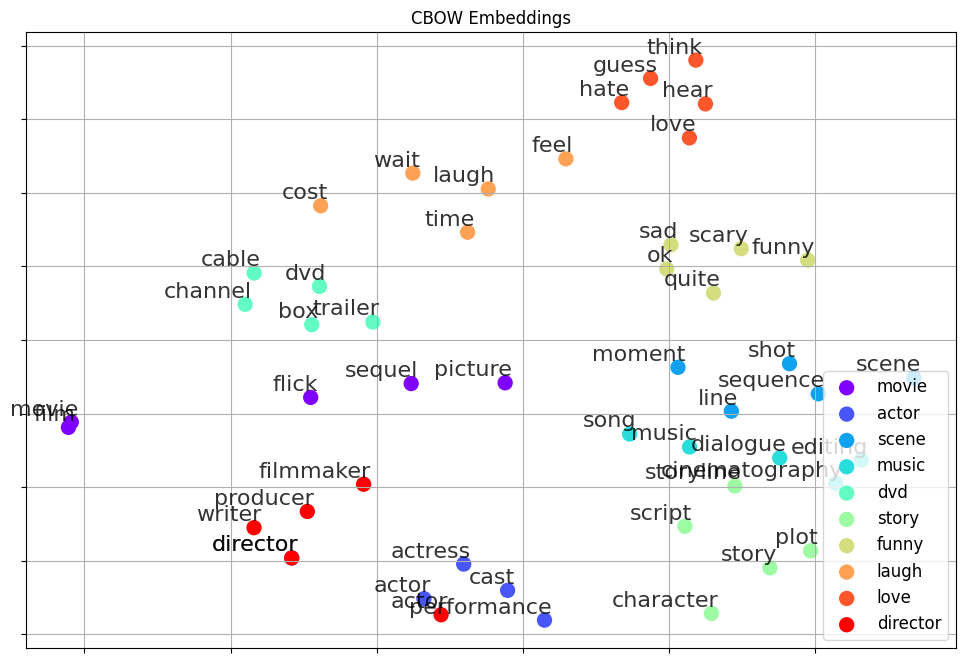

In [25]:
# Define list of seed words
seed_tokens = ['movie', 'actor', 'scene', 'music', 'dvd', 'story', 'funny', 'laugh', 'love', 'director']

# For each seed word, find all 5 most similar word and put them into a cluster + perform t-SNE
cbow_embedding_clusters, cbow_token_clusters = generate_tsne_embedding_clusters(seed_tokens, vocabulary, cbow_model)

# Plot clusters of 2d word embedding vectors
plot_embeddings("CBOW Embeddings", seed_tokens, cbow_embedding_clusters, cbow_token_clusters)

If you have used all the default parameters, you should see a plot where all clusters contain words that can be considered (very) similar. Of course, there will always be exceptions &mdash; after all, we are using just a small and domain-specific dataset (movie reviews). However, you may have noticed that words such *"funny"*, *"scary"*, *"sad"*, and *"hilarious"* are in the same cluster, as well as *"love"* and *"hate"*. Although not immediately intuitive, it matches the Distributional Hypothesis that Word2Vec implements. For example, both *"funny"* and *"sad"* are used to describe the story of a movie and are therefore likely to appear in similar contexts. This is a useful example to show that the Distributional Hypothesis does not capture all possible facets of a word's meaning. Here it clearly indicates that it is unable to capture words' polarity. Such insights are important when training models for sentiment classification.

---

## Skip-Gram

The **Skip-gram model** of Word2Vec is the "opposite" of the CBOW model: Instead of predicting the center or target word given the context words like in CBOW, Skip-gram is modeled to predict the context words given the center words. Using the same example, given the word *"movies"*, Skip-gram learns to predict the context words *"watching"*, *"funny"*, *"on"*, and *"netflix"*. Again, the order of the context words does not matter. The model architecture of SKip-gram is very similar to CBOW; see the figure below. Since Skip-gram takes in a single word, there is no longer a need to compute the average of multiple inputs embeddings. In contrast, Skip-gram has to compute multiple losses with respect to each predicted context word.

<img src="images/illustrations/word2vec/word2vec-skipgram-setup.png" style="margin:auto;max-width:800px;width:100%" alt="Word2Vec - Skip-gram" />

### Create Training Dataset

#### Generate Training Samples

Since the losses between a center word and all context words are independent from each other, we can treat each (center, context) pair as its own training samples. This means, given the example illustrated in the figure above with a window size of 2, we get the following 4 training samples.

> (*"movies"*, *"watching"*)  
(*"movies"*, *"funny"*)  
(*"movies"*, *"on"*)  
(*"movies"*, *"netflix"*)

Again, instead of the actual words, the training samples containing the corresponding word indices. Like before, we define a method `generate_skipgram_pairs()` that converts our long list of word indices into required format. More specifically, the method generates two lists, one containing all center words (`inputs`), and one containing all matching context words (`targets`). Like for CBOW training samples, using the `window_size` parameter, we can specify how many context words we want to consider.

In [26]:
def generate_skipgram_pairs(word_indices, window_size: int=4):
    inputs, targets = [], []
    for i in range(window_size, len(word_indices) - window_size):
        center_token = word_indices[i]
        pre_context =  word_indices[(i-window_size):i]
        post_context = word_indices[(i+1):(i+window_size+1)]
        context =  np.concatenate((pre_context, post_context))
        for context_token in context:
            inputs.append(center_token)
            targets.append(context_token)
    return torch.Tensor(np.asarray(inputs)).long(), torch.Tensor(np.asarray(targets)).long()

To generate a dataset for training a Skip-gram model, run the code cell below to apply method `generate_skipgram_pairs()` to list `word_indices` containing all word indices for the training corpus. We use the default parameters `window_size=4` to identify all context words for a given center word.

In [27]:
sg_inputs, sg_targets = generate_skipgram_pairs(word_indices)

print(f"Number of Skip-gram samples: {len(sg_inputs)}")
print(f"Example sample: ({sg_inputs[1]}, {sg_targets[1]})")

Number of Skip-gram samples: 18311888
Example sample: (1668, 372)


Since we create a training sample for pair of center word and context word, the total number of training samples is `2*window_size` time amount of entries in `word_indices` (ignoring the few words skipped at the beginning and at the end of `word_indices`).

#### Create `Dataset` & `DataLoader` Instances

For convenient training of the Skip-gram model using PyTorch, we once again create a `TensorDataset` instance and a `DataLoader` instance to wrap our training samples to handle the batching and shuffling. Notice that we use a larger batch size for the data loader instance since we have more training samples, but each training sample is smaller.

In [28]:
sg_dataset = TensorDataset(sg_inputs, sg_targets)

sg_loader = DataLoader(sg_dataset, batch_size=512, shuffle=True) 

inputs, targets = next(iter(sg_loader))
print("Contexts batch shape:", inputs.shape)
print("Targets batch shape:", targets.shape)

Contexts batch shape: torch.Size([512])
Targets batch shape: torch.Size([512])


### Define Skip-gram Model

The class `Skipgram` in the code cell below is almost identical to class `CBOW`. In fact, `Skipgram` is a bit simpler since the `forward()` method no longer requires to compute the mean/average of multiple input words like for CBOW. All other components &mdash; that is, input matrix $\mathbf{U}$, output matrix $\mathbf{V}$, and the loss function &mdash; are implemented exactly the same.

In [29]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(Skipgram, self).__init__()
        self.embed_size = embed_size
        self.V = nn.Embedding(vocab_size, embed_size, max_norm=1)
        self.U = nn.Linear(embed_size, vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5 / self.embed_size
        self.V.weight.data.uniform_(-initrange, initrange)
        self.U.weight.data.uniform_(-initrange, initrange)

    def forward(self, inputs, outputs):
        out = self.V(inputs)
        out = self.U(out)
        return self.criterion(out, outputs)

### Model Training

For defining the model and the training, we use the same parameters as for CBOW for consistency. In other words, we use the same size for the learned embeddings and the same optimizer (Adam) with the same learning rate (0.001). As usual, you are encouraged to train the model with different parameters to see how it might affect the resulting word embedding vectors.

In [30]:
sg_embed_dim = 100

# Create model
sg_model = Skipgram(len(vocabulary), sg_embed_dim)
# Define optimizer
sg_optimizer = optim.Adam(sg_model.parameters(), lr=0.001)
# Move th model to GPU, if available (by default it "stays" on the CPU)
sg_model.to(device)
# Print model
print(sg_model)

Skipgram(
  (V): Embedding(10002, 100, max_norm=1)
  (U): Linear(in_features=100, out_features=10002, bias=True)
  (criterion): CrossEntropyLoss()
)


For the actual training, we naturally use the method `train_epoch()` for convenience. Again for consistency, we train the model for 5 epochs, and print the 5 most similar words for *"movie"* and *"actor"* after each epoch to track the improvements. Keep in mind that training each epoch will take noticeably more time than for the CBOW model. This is because we now have `2*window_size` more training samples as before, and increasing the batch size cannot completely compensate for that.

In [31]:
num_epochs = 5

for epoch in range(num_epochs):
    description = f"Epoch {epoch+1}/{num_epochs}"
    train_epoch(sg_loader, sg_model, sg_optimizer, description)
    print(get_most_similar("movie", vocabulary, sg_model))
    print(get_most_similar("actor", vocabulary, sg_model))

print(f"Done training {num_epochs} epochs.")

['movie', 'film', 'it', 'one', 'i']
['actor', 'cast', 'director', 'performance', 'act']


['movie', 'film', 'it', 'i', 'this']
['actor', 'cast', 'actress', 'act', 'performance']


['movie', 'film', 'flick', 'it', 'i']
['actor', 'cast', 'actress', 'performance', 'role']


['movie', 'film', 'flick', 'sequel', 'it']
['actor', 'cast', 'actress', 'performance', 'role']


['movie', 'film', 'flick', 'movies', 'sequel']
['actor', 'cast', 'actress', 'performer', 'performance']
Done training 5 epochs.


For qualitatively comparing the result of CBOW and Skip-gram, let's create the plot showing the 5 most similar words for the same set of seed words using our two auxiliary methods `generate_tsne_embedding_clusters()` and `plot_embeddings()`. Of course, there is no expectation that the plot or even the sets of the 5 most similar words are indeed identical. It is mainly about to see if the cluster containing the 5 most similar words are indeed meaningful.

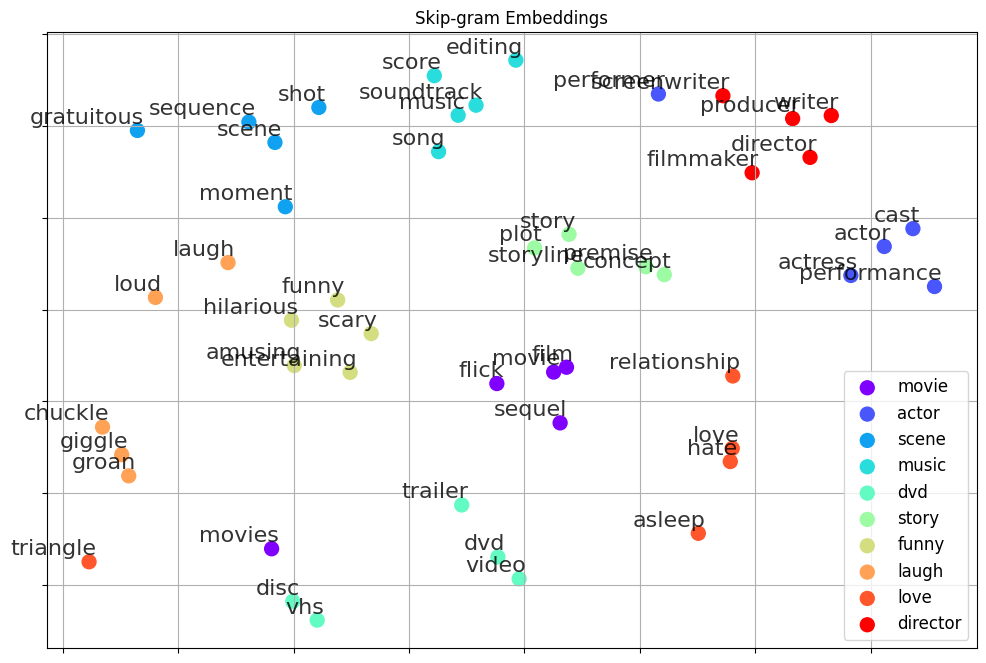

In [32]:
# Define list of seed words
seed_tokens = ['movie', 'actor', 'scene', 'music', 'dvd', 'story', 'funny', 'laugh', 'love', 'director']

# For each seed word, find all 5 most similar word and put them into a cluster + perform t-SNE
sg_embedding_clusters, sg_token_clusters = generate_tsne_embedding_clusters(seed_tokens, vocabulary, sg_model)

# Plot clusters of 2d word embedding vectors
plot_embeddings("Skip-gram Embeddings", seed_tokens, sg_embedding_clusters, sg_token_clusters)

Overall, the plots for the CBOW and Skip-gram model are very similar in the sense that each word cluster does indeed contain words that are semantically (very) similar. This should not be very surprising since CBOW and Skip-gram are closely related architectures. However, in practice, CBOW and Skip-gram show some different behaviors which we will discuss at the end. And once again, we can see that the Word2Vec fails to capture the polarity of words such as *"love"* and *"hate"* but considers them as very similar &mdash; which they are with respect to the Distributional Hypothesis!

---

## Skip-Gram with Negative Sampling (SGNS)

The **Skip-Gram with Negative Sampling (SGNS)** model is an efficient variant of the basic Skip-gram model used in Word2Vec. In the standard Skip-gram setup, the model tries to predict all context words surrounding a target word by maximizing the probability of these context words given the target. This requires computing a softmax over the entire vocabulary for every prediction &mdash; a very expensive operation when the vocabulary is large. SGNS simplifies this process by reformulating the task into a series of binary classification problems: given a pair of words, the model learns to distinguish between real (observed) word-context pairs and random (noise) pairs.

Instead of computing probabilities for all words, SGNS uses a small number of **negative samples** (randomly chosen words) for each positive (true) pair. The model is trained to output a high score for real pairs and a low score for negative pairs, typically using a logistic loss (or binary cross-entropy loss). This greatly reduces computational cost while still allowing the embeddings to capture meaningful semantic relationships between words. Thus, for our example center word and corresponding context words, the positive samples together with "some" negative sample would look conceptually as follows:

> ([*"movies"*, *"watching"*], **1**)  
([*"movies"*, *"funny"*], **1**)  
([*"movies"*, *"on"*], **1**),   
([*"movies"*, *"netflix"*], **1**)  
([*"movies"*, *"tall"*], **0**)  
([*"movies"*, *"from"*], **0**)  
([*"movies"*, *"elephant"*]), **0**),   
([*"movies"*, *"because"*], **0**)  
([*"movies"*, *"train"*], **0**)  
([*"movies"*, *"delicious"*], **0**)  
([*"movies"*, *"separate"*], **0**),   
([*"movies"*, *"still"*], **0**)

Here, the true or **positive samples** (i.e., the samples representing true pairs of center and context words) are labeled with $1$. The samples labeled with $0$ are the **negative samples** and are pairs of center words and other words that are (generally) *not* context words of the center word. In general, negative samples are generated randomly by selecting words from the vocabulary and pairing them with a given center word. While a random word might be a context word of the center word somewhere in the corpus, the probability is negligible (assuming a sufficiently large vocabulary). However, some additional steps are needed to effectively train SGNS embeddings, as we will discuss in a bit.

In principle, we could use our list of word indices to generate the train samples to each contain an explicit label ($0$ or $1$) and train a binary classification model. However, we can use the fact the loss function of Skip-Gram with Negative Sampling is defined as follows:

$$\large
L_{SGNS} = - \left[ \sum_{(c,m)\in B_{pos}} \log{\sigma\left(\mathbf{u_{m}^\top}\mathbf{v}_{c} \right)} + \sum_{(c,m)\in B_{neg}} \log{\sigma\left(-\mathbf{u_{m}^\top}\mathbf{v}_{c} \right)} \right]
$$

where $B_{pos}$ is the batch containing the positive samples, and $B_{neg}$ is the batch containing the negative samples. $\mathbf{v}_c$ is the embedding vector for the center words derived from the input weight matrix $\mathbf{U}$, and $\mathbf{v}_m$ is the embedding vector of the $m$-th context word derived from the output weight matrix $\mathbf{U}$. Calculating this loss directly is in practice more efficient. However, since this is not a standard loss function available in PyTorch, we first need to implement it ourselves (see the following code cell).

In [33]:
class NegativeSamplingLoss(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, v_c, u_pos, u_neg):
        # Computes positive scores and losses
        pos_score = torch.bmm(u_pos.unsqueeze(1), v_c.unsqueeze(2)).squeeze()
        pos_loss = F.logsigmoid(pos_score)

        #  Compute negative scores and losses
        neg_score = torch.bmm(u_neg, v_c.unsqueeze(2)).squeeze()
        neg_loss = F.logsigmoid(-neg_score).sum(1)

        # Return total loss (negative log-likelihood)
        return -(pos_loss + neg_loss).mean()

This implementation, `u_pos` represents all context word embeddings in the positive samples, and `u_neg` all context word embeddings in the negative samples. The rest of the forward method directly implements the formula for $L_{SGNS}$ as shown above. While for CBOW and Skip-gram we could simply use the `nn.CrossEntropyLoss` of PyTorch, our SGNS will have to use this custom `NegativeSamplingLoss`.

In principle, we could now generate our training samples similar to Skip-gram and train a model. However, training a SGNS model turns out to be much more challenging compared to a basic Skip-gram model. SGNS often relies on **subsampling** and **smoothing** because natural language data is highly unbalanced where a few very common words (like *"the"*, *"is"*, *"and"*) appear extremely often, while most words appear rarely. Without correction, these frequent words dominate training, causing the model to waste effort learning uninformative patterns and overshadowing meaningful relationships among rarer, more content-rich words. **Subsampling** mitigates this by randomly discarding very frequent words according to a probability that increases with frequency, allowing the model to focus on more informative co-occurrences.

**Smoothing** is applied when drawing **negative samples**. In SGNS, negative words are sampled from the vocabulary based on word frequency, but if raw frequencies are used, the negatives are still too often common words, and thus again reducing training diversity. To fix this, SGNS uses a smoothed distribution. This adjustment slightly reduces the probability of sampling very frequent words as negatives, improving the balance between common and rare words during training. Together, subsampling and smoothing help SGNS learn higher-quality embeddings that better reflect semantic relationships. Subsampling improves efficiency and representation of rare words, while smoothing ensures that negative samples are informative rather than repetitive. These techniques prevent the model from overfitting to frequency statistics and instead push it to capture deeper contextual similarities between words. Let's have a look at how subsampling and smoothing is typically implemented.

### Create Training Dataset

#### Generate Training Samples

Recall that for CBOW and Skip-gram, we simply had to iterate over `word_indices` to create the training samples to match the expected format of the two models. While we still need to do this, there are now also subsampling and smoothing to be considered. Where therefore implement a custom `Dataset` class for the SGNS model; see the implementation of class `SGNSDataset` in the code cell below.

**Subsampling.** When iterating through all indices in `word_indices`, we randomly decide if we want to consider the current word index as a center word. The probability $P(w_i)$ of *keeping* a word $w_i$ (i.e., considering it as a center word) is computed using the following formula:

$$\large
P(w_i) = \min\left(1, \sqrt{\frac{t}{f(w_i)}} + \frac{t}{f(w_i)} \right)
$$

where $f(w_i)$ is the **relative frequency** of word $w_i$ in the corpus (i.e., its count divided by the total number of tokens), and $t$ is a small **threshold**, typically around $10^{-5}$, controlling how aggressively frequent words are downsampled. In practice, this means very frequent words have a much smaller chance of being kept, while rare words are almost always retained. This formula is implemented by the `self.keep_probs` variable in the `SGNSDataset` class.

**Smooting.** In SGNS, smoothing is applied when selecting negative samples to ensure a balanced mix of common and rare words. Instead of sampling negatives directly from the raw unigram distribution $U(w)$, the model samples from a **smoothed distribution** defined as:

$$\large
P(w) = \frac{U(w)^{3/4}}{Z}
$$

where $U(w)$ is the **unigram probability** of word $w$ (its frequency divided by the total number of tokens), the exponent $3/4$ is a **smoothing factor** chosen empirically, and $Z = \sum_{w'} U(w')^{3/4}$ is a normalization constant ensuring $P(w)$ sums to 1. This smoothing reduces the probability of sampling very frequent words and increases the chance of sampling less frequent ones as negative examples. In the `SGNSDataset` class, smoothing is implemented by the variable `self.neg_sampling_dist`.

Finally, the class method `_generate_pairs()` iterates overall word indices of the corpus to generate the pairs of center and context words, very similar to Skip-gram. However, this method now uses `self.keep_probs` to perform subsampling and skip high-frequency words with a high probability. Notice that `_generate_pairs()` only generates the positive samples. The negative samples are generated "on-the-fly" during training, but utilizing the `self.neg_sample_dist` variable of the data loader class.

In [34]:
class SGNSDataset(Dataset):

    def __init__(self, word_indices, vocabulary, context_size: int=4, subsample_threshold: float=1e-5):
        self.context_size = context_size
        self.subsample_threshold = subsample_threshold
    
        self.word_counts = torch.FloatTensor(vocabulary.token_counts)

        total_words = sum(self.word_counts)
        freqs = self.word_counts / total_words

        # Compute the probabilties for each word index to be considered as a center word
        self.keep_probs = torch.sqrt(self.subsample_threshold / freqs) + (self.subsample_threshold / freqs)
        self.keep_probs = torch.nan_to_num(self.keep_probs, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Compute negative sampling distribution (P(w)^0.75)
        self.neg_sampling_dist = (self.word_counts ** 0.75)
        self.neg_sampling_dist /= self.neg_sampling_dist.sum()

        self.word_pairs = self._generate_pairs(word_indices)
    
    def _generate_pairs(self, word_indices):
        word_pairs = []
        for i, center in enumerate(word_indices):
            # Subsampling: skip some frequent words
            if np.random.random() > self.keep_probs[center]:
                continue
            
            # Context window
            window = np.random.randint(1, high=self.context_size)
            for j in range(-window, window + 1):
                if j == 0 or i + j < 0 or i + j >= len(word_indices):
                    continue
                context = word_indices[i + j]
                word_pairs.append((center, context))
        
        return torch.Tensor(np.asarray(word_pairs)).long()

    
    def __len__(self):
        return len(self.word_pairs)
    
    def __getitem__(self, idx):
        # Retrieve one (center, context) pair
        inputs, targets = self.word_pairs[idx]

        return inputs.long(), targets.long()

#### Create `Dataset` & `DataLoader` Instances

We can now create an instance of the `SGNSDataset` class, as well as an instance of `DataLoader` using this dataset instance is input to wrap our dataset for the training; this is completely analogous to the steps we have already seen for the CBOW and (basic) Skip-gram model.

In [35]:
sgns_dataset = SGNSDataset(word_indices, vocabulary)

sgns_loader = DataLoader(sgns_dataset, batch_size=256, shuffle=True) 

inputs, targets = next(iter(sgns_loader))
print("Contexts batch shape:", inputs.shape)
print("Targets batch shape:", targets.shape)

Contexts batch shape: torch.Size([256])
Targets batch shape: torch.Size([256])


### Define Skip-gram Model

The class `SkipgramNS` in the code cell below extends/modifies the previous `Skipgram` class in two main ways. Firstly, the `forward()` method now generates the random samples using the smoothing probabilities (i.e., `self.neg_sampling_dist`). And secondly, this class now uses the custom `NegativeSamplingLoss` as the loss function. An important additional parameter is `n_samples` which specifies the number of negative samples for a given positive sample. Common values for `n_samples` are of the range 5-10 in practice.

In [36]:
class SkipgramNS(nn.Module):
    
    def __init__(self, vocab_size, embed_size, n_samples=10, neg_sampling_dist=None):
        super(SkipgramNS, self).__init__()
        self.embed_size = embed_size
        self.n_samples = n_samples
        self.neg_sampling_dist = neg_sampling_dist
        self.V = nn.Embedding(vocab_size, embed_size)
        self.U = nn.Embedding(vocab_size, embed_size)
        self.criterion = NegativeSamplingLoss()
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5 / self.embed_size
        self.V.weight.data.uniform_(-initrange, initrange)
        self.U.weight.data.uniform_(-initrange, initrange)

    def forward(self, centers, contexts):
        batch_size = centers.size(0)
        # Default to uniform noise if no distribution provided
        neg_sampling_dist = self.neg_sampling_dist if self.neg_sampling_dist is not None else torch.ones(self.vocab_size)

        # Sample noise word indices for negative samples
        neg_contexts = torch.multinomial(neg_sampling_dist, batch_size * self.n_samples, replacement=True)
        neg_contexts = neg_contexts.to(self.U.weight.device)

        # Compute all relevant embedding vectors
        v_c = self.V(centers)
        u_pos = self.U(contexts)
        u_neg = self.U(neg_contexts).view(batch_size, self.n_samples, self.embed_size)

        # Compute and return the loss
        return self.criterion(v_c, u_pos, u_neg)

### Model Training

The steps for the actual training are the same as for CBOW and Skip-gram. We first need to define the model and optimizer instance; again, we use the same values (i.e., Adam optimizer with a learning rate of 0.001) as before to allow for a direct comparison. Notice how we pass the smoothing probabilities (`neg_sampling_dist`) we have computed within the dataset instance to the SGNS model as an input parameter.

In [37]:
sgns_embed_dim = 100

# Create model
sgns_model = SkipgramNS(len(vocabulary), sgns_embed_dim, n_samples=10, neg_sampling_dist=sgns_dataset.neg_sampling_dist)
# Define optimizer
sgns_optimizer = optim.Adam(sgns_model.parameters(), lr=0.001)
# Move th model to GPU, if available (by default it "stays" on the CPU)
sgns_model.to(device)
# Print model
print(sgns_model)

SkipgramNS(
  (V): Embedding(10002, 100)
  (U): Embedding(10002, 100)
  (criterion): NegativeSamplingLoss()
)


Let's the train the SNGS model for 5 epochs using our `train_epoch()` method &mdash; and observe the progress by printing the 5 most similar words for *"movie"* and *"actor"* after each epoch.

In [38]:
num_epochs = 5

for epoch in range(num_epochs):
    description = f"Epoch {epoch+1}/{num_epochs}"
    train_epoch(sgns_loader, sgns_model, sgns_optimizer, description)
    print(get_most_similar("movie", vocabulary, sgns_model))
    print(get_most_similar("actor", vocabulary, sgns_model))

print(f"Done training {num_epochs} epochs.")

['movie', 'film', 'one', 'low', 'avoid']
['actor', 'talented', 'miscast', 'bland', 'irritate']


['movie', 'film', 'flick', 'documentary', 'kentucky']
['actor', 'actress', 'cast', 'role', 'talented']


['movie', 'flick', 'anthology', 'edinburgh', 'category']
['actor', 'actress', 'cast', 'performer', 'comedian']


['movie', 'category', 'anthology', 'flick', 'edinburgh']
['actor', 'actress', 'cast', 'comedian', 'performer']


['movie', 'anthology', 'flick', 'definitely', 'category']
['actor', 'actress', 'cast', 'comedian', 'performer']
Done training 5 epochs.


Using the train model, we again can assess the quality of the learned embeddings by plotting the clusters of most similar words for a set of seed words. By default, we use the same seed words as for CBOW and Skip-gram for a direct comparison. However, you are welcome to try your own words.

CPU times: user 1.38 s, sys: 2.98 ms, total: 1.39 s
Wall time: 298 ms


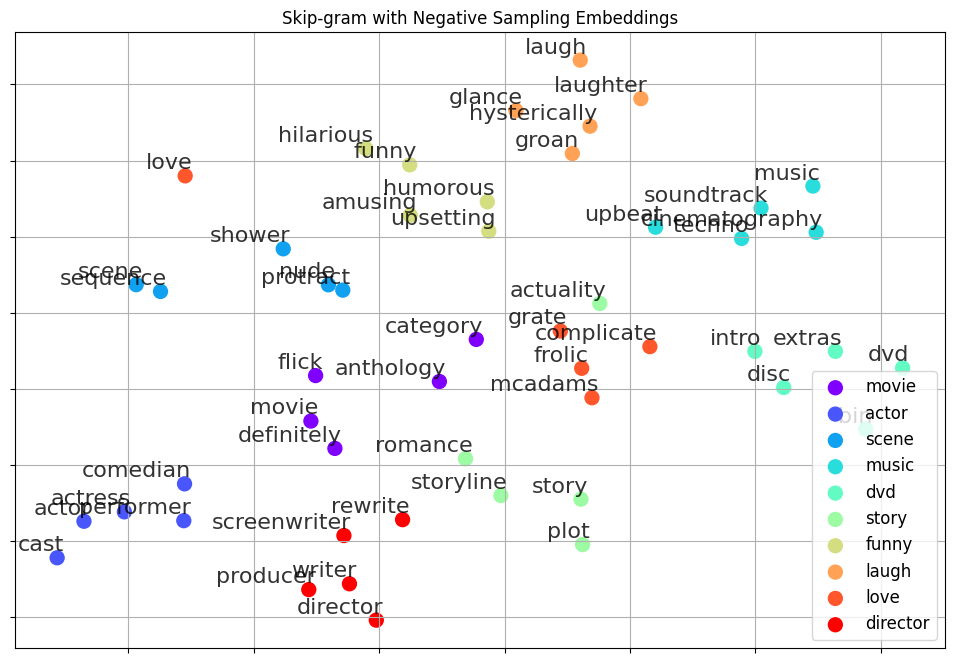

In [39]:
%%time

seed_tokens = ['movie', 'actor', 'scene', 'music', 'dvd', 'story', 'funny', 'laugh', 'love', 'director']

sgns_embedding_clusters, sgns_token_clusters = generate_tsne_embedding_clusters(seed_tokens, vocabulary, sgns_model)

plot_embeddings("Skip-gram with Negative Sampling Embeddings", seed_tokens, sgns_embedding_clusters, sgns_token_clusters)

Compared to CBOW and Skip-gram, at least after 5 epochs, the results might not look quite as good, with some words looking a bit out of place. Skip-Gram with Negative Sampling (SGNS) is typically more challenging to train than the basic CBOW and Skip-gram models because it introduces stochasticity and additional complexity through its negative sampling process. Unlike the basic models, which compute a single softmax probability distribution over the entire vocabulary, SGNS must generate and train on several random negative samples for every positive word-context pair. This increases the variance of gradient updates and makes the learning process more sensitive to hyperparameters such as the number of negative samples, the learning rate, and the subsampling threshold.

Moreover, SGNS relies on the balance between positive and negative examples to shape the embedding space correctly. If negative samples are poorly chosen or too few, the model may fail to distinguish meaningful word relationships; if too many are used, training becomes inefficient and unstable. In contrast, CBOW and basic Skip-gram use a more deterministic training signal and converge more smoothly, though at a higher computational cost. SGNS trades off this stability for speed and scalability, making it both powerful and trickier to tune effectively.

---

## Summary

This notebook explored the **implementation and training of different Word2Vec models** &mdash; Continuous Bag-of-Words (CBOW), Skip-Gram, and Skip-Gram with Negative Sampling (SGNS) &mdash; entirely from scratch using Python and PyTorch. The main goal was not to achieve state-of-the-art embeddings, but to develop a **deeper conceptual understanding** of how Word2Vec learns word representations from co-occurrence data. By implementing each model manually, we gained hands-on insight into the mechanics of context prediction, embedding updates, and how vector spaces emerge through training.

The **CBOW model** was implemented first, demonstrating how averaging context word embeddings can predict a target word. Next, the **Skip-Gram model** reversed this relationship by predicting context words from a target word, allowing it to capture richer semantic information at the cost of more computations. Finally, the **SGNS model** introduced negative sampling to make training more efficient by replacing the costly softmax computation with a binary classification task between real and randomly sampled word pairs. Through this progression, we observed how each variant balances **accuracy, efficiency, and interpretability** differently.

Training experiments revealed the **strengths** of Word2Vec: the embeddings successfully captured semantic relationships between words. However, we also encountered **limitations**, particularly the model's difficulty in capturing **word polarity or nuanced meanings**. For example, words like *"good"* and *"bad"* may appear close in the embedding space because they share similar syntactic and contextual patterns, despite having opposite meanings. This illustrates that Word2Vec focuses on **contextual co-occurrence**, not on the sentiment or polarity of words.

Overall, this notebook emphasized the educational value of building Word2Vec models from scratch. It highlighted how distributional semantics emerges naturally from prediction-based learning, while also demonstrating the constraints of such models when handling deeper semantic, emotional, or contextual subtleties. The exercise not only clarified the inner workings of Word2Vec but also set the stage for understanding more advanced embedding methods like GloVe and contextual models such as BERT.